# Gaussian Mixture Models (GMM) Clustering
### CMPE 255 — Data Mining  

In this notebook, I will:

- Explain the intuition behind **Gaussian Mixture Models (GMM)**
- Use `GaussianMixture` from `sklearn.mixture` (not from scratch)
- Compare GMM with **K-Means**
- Visualize clusters and decision boundaries (in 2D)
- Evaluate clustering quality using:
  - Silhouette Score
  - Davies–Bouldin Index
  - Calinski–Harabasz Score
- Use **soft assignments** (cluster probabilities)
- Use **AIC/BIC** to compare models with different numbers of components


## 1. Theory: What is a Gaussian Mixture Model?

A **Gaussian Mixture Model (GMM)** assumes that the data is generated from a mixture of several **Gaussian (normal) distributions**.

Mathematically, the probability density of a point \\(x\\) is:

\\[
p(x) = \sum_{k=1}^{K} \pi_k \, \mathcal{N}(x \mid \mu_k, \Sigma_k)
\\]

Where:
- \\(K\\) = number of components (clusters)  
- \\(\pi_k\\) = mixture weights (sum to 1)  
- \\(\mu_k\\) = mean of component \\(k\\)  
- \\(\Sigma_k\\) = covariance matrix of component \\(k\\)  

---

### GMM vs K-Means

- **K-Means**:  
  - Hard assignments: each point belongs to exactly one cluster  
  - Uses only cluster **means** (centroids)  
  - Assumes spherical clusters with equal variance  

- **GMM**:  
  - Soft assignments: each point has **probabilities** for each cluster  
  - Uses **means + covariances**  
  - Can model **elliptical** clusters and different shapes  

---

### How is GMM trained?

GMM is typically trained using the **EM (Expectation–Maximization)** algorithm:

1. **E-step**: compute the probability that each point belongs to each component  
2. **M-step**: update parameters (means, covariances, and weights) using these probabilities  
3. Repeat until convergence.  


In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    calinski_harabasz_score
)

plt.rcParams["figure.figsize"] = (6, 5)


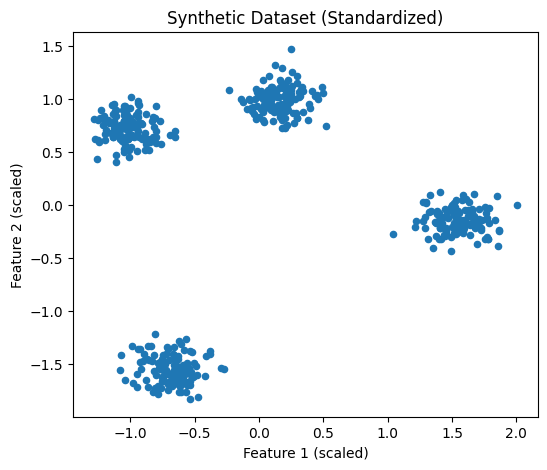

In [2]:
# Generate synthetic data
X, y_true = make_blobs(
    n_samples=500,
    centers=4,
    cluster_std=0.8,
    random_state=42
)

# Scale data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Visualize
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], s=20)
plt.title("Synthetic Dataset (Standardized)")
plt.xlabel("Feature 1 (scaled)")
plt.ylabel("Feature 2 (scaled)")
plt.show()


In [3]:
n_components = 4

gmm = GaussianMixture(
    n_components=n_components,
    covariance_type="full",
    random_state=42
)

gmm.fit(X_scaled)

# Hard labels (most probable cluster for each point)
labels_gmm = gmm.predict(X_scaled)

# Soft assignments (probabilities)
probs_gmm = gmm.predict_proba(X_scaled)

print("GMM fitted.")
print("Cluster weights (pi_k):", gmm.weights_)
print("Means shape:", gmm.means_.shape)
print("Covariances shape:", gmm.covariances_.shape)


GMM fitted.
Cluster weights (pi_k): [0.25 0.25 0.25 0.25]
Means shape: (4, 2)
Covariances shape: (4, 2, 2)


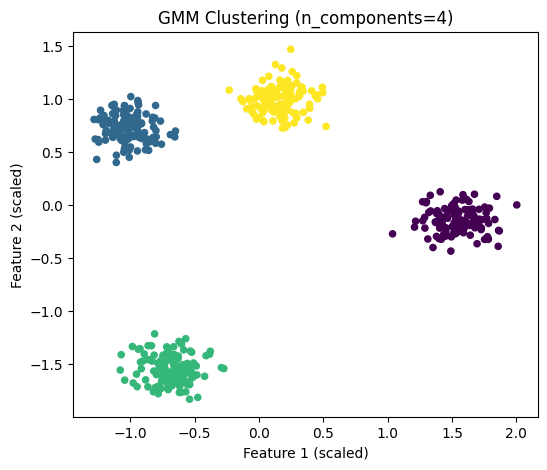

In [4]:
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=labels_gmm, cmap="viridis", s=20)
plt.title(f"GMM Clustering (n_components={n_components})")
plt.xlabel("Feature 1 (scaled)")
plt.ylabel("Feature 2 (scaled)")
plt.show()


In [5]:
sil_gmm = silhouette_score(X_scaled, labels_gmm)
db_gmm = davies_bouldin_score(X_scaled, labels_gmm)
ch_gmm = calinski_harabasz_score(X_scaled, labels_gmm)

print("📌 GMM Clustering Metrics")
print(f"Silhouette Score       : {sil_gmm:.4f}")
print(f"Davies–Bouldin Index   : {db_gmm:.4f}")
print(f"Calinski–Harabasz Score: {ch_gmm:.4f}")


📌 GMM Clustering Metrics
Silhouette Score       : 0.8393
Davies–Bouldin Index   : 0.2247
Calinski–Harabasz Score: 8696.8128


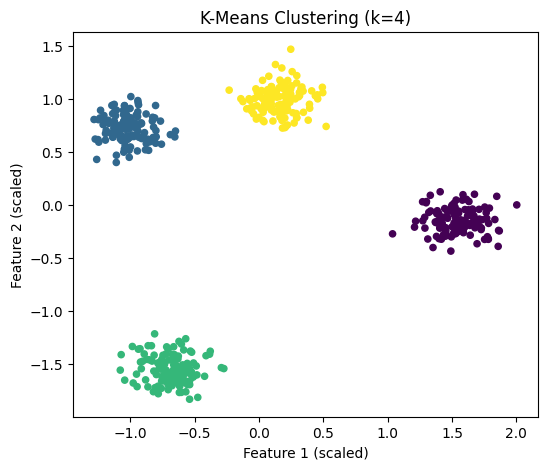

📌 K-Means Clustering Metrics
Silhouette Score       : 0.8393
Davies–Bouldin Index   : 0.2247
Calinski–Harabasz Score: 8696.8128


In [6]:
kmeans = KMeans(
    n_clusters=n_components,
    random_state=42,
    n_init="auto"
)
labels_kmeans = kmeans.fit_predict(X_scaled)

plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=labels_kmeans, cmap="viridis", s=20)
plt.title(f"K-Means Clustering (k={n_components})")
plt.xlabel("Feature 1 (scaled)")
plt.ylabel("Feature 2 (scaled)")
plt.show()

sil_km = silhouette_score(X_scaled, labels_kmeans)
db_km = davies_bouldin_score(X_scaled, labels_kmeans)
ch_km = calinski_harabasz_score(X_scaled, labels_kmeans)

print("📌 K-Means Clustering Metrics")
print(f"Silhouette Score       : {sil_km:.4f}")
print(f"Davies–Bouldin Index   : {db_km:.4f}")
print(f"Calinski–Harabasz Score: {ch_km:.4f}")


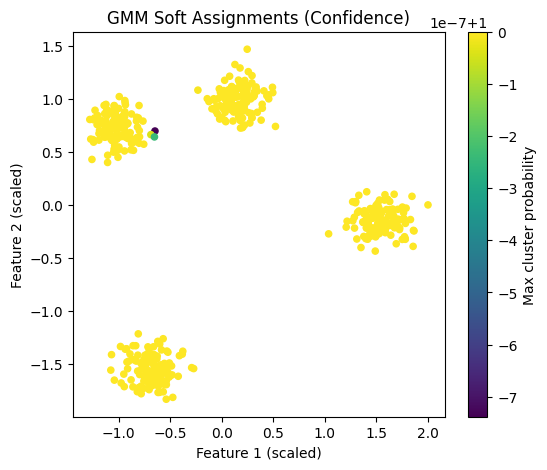

In [7]:
# Max probability per point across clusters
max_probs = probs_gmm.max(axis=1)

plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=max_probs, cmap="viridis", s=20)
plt.colorbar(label="Max cluster probability")
plt.title("GMM Soft Assignments (Confidence)")
plt.xlabel("Feature 1 (scaled)")
plt.ylabel("Feature 2 (scaled)")
plt.show()


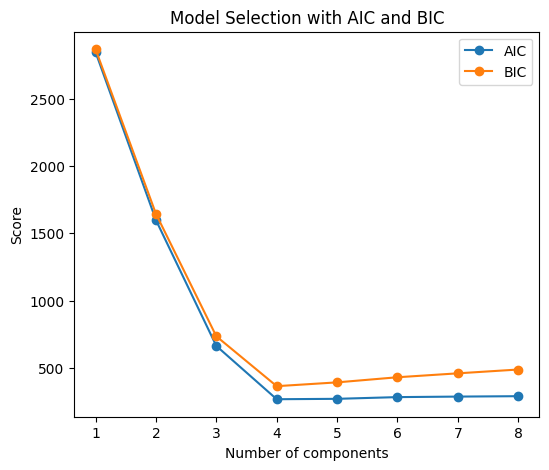

In [8]:
components_range = range(1, 9)
aics = []
bics = []

for c in components_range:
    gmm_c = GaussianMixture(
        n_components=c,
        covariance_type="full",
        random_state=42
    )
    gmm_c.fit(X_scaled)
    aics.append(gmm_c.aic(X_scaled))
    bics.append(gmm_c.bic(X_scaled))

plt.plot(components_range, aics, marker="o", label="AIC")
plt.plot(components_range, bics, marker="o", label="BIC")
plt.xlabel("Number of components")
plt.ylabel("Score")
plt.title("Model Selection with AIC and BIC")
plt.legend()
plt.show()


## Conclusions and Observations

- I used **Gaussian Mixture Models (GMM)** from `sklearn.mixture` (not from scratch).
- The data was standardized and clustered using **4 components**.
- I visualized GMM cluster assignments and compared them with **K-Means** on the same dataset.
- I computed clustering quality metrics:
  - Silhouette Score
  - Davies–Bouldin Index
  - Calinski–Harabasz Score

### GMM vs K-Means (my results)
- [Write here: e.g., GMM gave slightly better/worse Silhouette score than K-Means.]
- GMM can model **elliptical clusters** and provides **soft assignments** (probabilities).
- K-Means is simpler and faster but assumes spherical clusters and hard assignments.

### Model selection
- I plotted **AIC/BIC** for different numbers of components.
- The best number of components is around **[fill based on your plot]** according to AIC/BIC.

This notebook completes **Part (c): Gaussian Mixture Models clustering (not from scratch)** for the CMPE 255 assignment.
